# Introduction #
Welcome. Let automate machine learning as much as possible.
<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

Bugs:
AK - No val_loss, val_accuracy from history.

## Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# from category_encoders import MEstimateEncoder
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from IPython.display import clear_output
# !pip install -q -U keras-tuner
# clear_output()
import keras_tuner as kt

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

# Parameters


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
MAX_TRIAL = 1 # speed trial any%
EPOCHS = 60

# not used
BATCH_SIZE = 2048 # large enough to fit RAM
ACTIVATION = 'selu'
KERNEL_INIT = "glorot_uniform" # lecun_normal
LEARNING_RATE = 0.000965713 # Optimal lr is about half the maximum lr
LR_FACTOR = 0.5 # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau
ES_PATIENCE = 10
RLRP_PATIENCE = 5
DROPOUT = 0.15

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

RANDOM_STATE = 31
VERBOSE = 1

# The dataset is too huge for free contrainer. Sampling it for more fun!
SAMPLE = 195712 # [1468136, 2262087, 195712, 377, 1, 11426, 62261] # 4000000 total rows
VALIDATION_SPLIT = 0.25

# Admin
ID = "Id" # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [3]:
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    df_train = reduce_mem_usage(df_train)
    df_test = reduce_mem_usage(df_test)
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [4]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [6]:
%%time
df_train, df_test = load_data()

Mem. usage decreased to 274.66 Mb (83.9% reduction)
Mem. usage decreased to 67.71 Mb (83.9% reduction)
CPU times: user 27 s, sys: 10.8 s, total: 37.8 s
Wall time: 42.9 s


In [7]:
# Peek at the values
display(df_train)
# display(df_test)

# Display information about dtypes and missing values
# display(df_train.info())
# display(df_test.info())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618,...,0,0,0,0,0,0,0,0,0,2
3999996,2926,104,8,696,83,5427,210,216,150,2863,...,0,0,0,0,0,0,0,0,0,2
3999997,2911,144,1,509,58,4820,195,192,91,92,...,0,0,0,0,0,0,0,1,0,2


In [8]:
TARGET_FEATURE_NAME = df_train.columns.difference(df_test.columns)[0]

In [9]:
# customized XY TBR
idx = df_train[df_train[TARGET_FEATURE_NAME] == 4].index
df_train.drop(idx, axis = 0, inplace = True)
idx = df_train[df_train[TARGET_FEATURE_NAME] == 5].index
df_train.drop(idx, axis = 0, inplace = True)
# idx = train_data[train_data[column_y] == 6].index # Less then 0.5% significant different, dropped
# train_data.drop(idx, axis = 0, inplace = True)

cols = ["Soil_Type7", "Soil_Type15"]
df_train.drop(cols, axis = 1, inplace= True)
df_test.drop(cols, axis = 1, inplace = True)

In [10]:
X_raw = df_train.drop(columns=TARGET_FEATURE_NAME)
y_raw = df_train[TARGET_FEATURE_NAME]

X_test_raw = df_test.iloc[:,:]
TARGET_FEATURE_NAME

'Cover_Type'

# Resampling

Auto Keras y categories calculation wrong when cat 5 is missing etc

In [11]:
from sklearn.model_selection import train_test_split
# Check NA
missing_val = X_raw.isnull().sum()
print(missing_val[missing_val > 0])

Series([], dtype: int64)


In [12]:
sampling_key, sampling_count = np.unique(y_raw, return_counts=True)
sampling_count[sampling_count > SAMPLE] = SAMPLE
zip_iterator = zip(sampling_key, sampling_count)
sampling_params = dict(zip_iterator)

undersample = RandomUnderSampler(
    sampling_strategy=sampling_params)

X_raw, y_raw = undersample.fit_resample(X_raw, y_raw)

In [13]:
np.unique(y_raw, return_counts=True)

(array([1, 2, 3, 6, 7], dtype=int8),
 array([195712, 195712, 195712,  11426,  62261]))

## Scaler transformer
By using RobustScaler(), we can remove the outliers. No good for this dataset test.
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [14]:
transformer_all_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_all_cols, X_raw.columns[:]),
)

In [15]:
X_train = preprocessor.fit_transform(X_raw)
X_test = preprocessor.transform(X_test_raw)

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_raw) # Prepare for multiclass classification

In [17]:
le.classes_

array([1, 2, 3, 6, 7], dtype=int8)

In [18]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([195712, 195712, 195712,  11426,  62261]))

In [19]:
X_raw[TARGET_FEATURE_NAME] = y_train

In [20]:
train, val = train_test_split(X_raw, test_size=VALIDATION_SPLIT, stratify=X_raw[[TARGET_FEATURE_NAME]], random_state=RANDOM_STATE)

In [21]:
X_train = train.drop(columns=TARGET_FEATURE_NAME)
y_train = train[[TARGET_FEATURE_NAME]]
X_val = val.drop(columns=TARGET_FEATURE_NAME)
y_val = val[[TARGET_FEATURE_NAME]]

TPS always have huge dataset.

In [22]:
import gc
del df_train
del df_test
del X_raw
del y_raw
del X_test_raw
gc.collect()

280

In [23]:
TARGET_FEATURE_LABELS = np.unique(y_train)
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X_train.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

# Hyperparameter Tuning #

At this stage, you might like to do auto hyperparameter tuning with AutoKeras before creating your final submission.
AutoKeras: An AutoML system based on Keras. It is developed by DATA Lab at Texas A&M University. The goal of AutoKeras is to make machine learning accessible to everyone.

By default, AutoKeras use the last 20% of training data as validation data. As shown in the example below, you can use validation_split to specify the percentage.

In [24]:
# y_train = tf.keras.utils.to_categorical(y_train, OUTPUT_SHAPE)

In [25]:
# Search for the best model with EarlyStopping.
stop_early = tf.keras.callbacks.EarlyStopping(
                                    patience=ES_PATIENCE,
                                    monitor='val_loss',
#                                     mode='min',
#                                     restore_best_weights=True,       
#                                     verbose=VERBOSE,
                                    )
reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
                                    factor=LR_FACTOR,
                                    patience=RLRP_PATIENCE,
                                    monitor='val_loss',
#                                     mode='min',
#                                     verbose=VERBOSE,
                                    )

In [26]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(INPUT_SHAPE,)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=64, max_value=256, step=64)
    hp_units2 = hp.Int('units2', min_value=16, max_value=256, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.05, max_value=0.5, step=0.05)
    
    model.add(keras.layers.Dense(units=hp_units1, kernel_initializer = KERNEL_INIT, activation=ACTIVATION))
    model.add(layers.AlphaDropout(rate = hp_dropout))
    model.add(layers.BatchNormalization())
    model.add(keras.layers.Dense(units=hp_units2, kernel_initializer = KERNEL_INIT, activation=ACTIVATION))
    model.add(layers.AlphaDropout(rate = hp_dropout))
    model.add(layers.BatchNormalization())
    model.add(keras.layers.Dense(units=hp_units2, kernel_initializer = KERNEL_INIT, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SHAPE)) #, activation = 'softmax'

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [27]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', # val_accuracy
                     max_epochs=21,
                     factor=3,
                     directory='kt_softmax',
                     project_name='kt_softmax',
                     seed=RANDOM_STATE)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [28]:
%%time
tuner.search(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val),
                callbacks=[stop_early, reduceLROnPlateau])

# Get the optimal hyperparameters ,seed=RANDOM_STATE
best_hps=tuner.get_best_hyperparameters(num_trials=MAX_TRIAL)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}  {best_hps.get('units2')} and the optimal dropout rate for the optimizer
is {best_hps.get('dropout_rate')}.
""")
tuner.results_summary()

Trial 30 Complete [00h 14m 11s]
val_accuracy: 0.36230525374412537

Best val_accuracy So Far: 0.6127259135246277
Total elapsed time: 04h 07m 37s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64  240 and the optimal dropout rate for the optimizer
is 0.05.

Results summary
Results in kt_softmax/kt_softmax
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 64
units2: 240
dropout_rate: 0.05
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: d1a2d449f6c98d0783cd9a3ae648ef16
Score: 0.6127259135246277
Trial summary
Hyperparameters:
units1: 256
units2: 96
dropout_rate: 0.1
tuner/epochs: 21
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 7eee1fac5509279045fa4fba8b06229c
Score: 0.5489025712013245
Trial summary
Hyperparameters:
units1: 64
units2: 128
dropout_rate: 0.4
tuner/epochs: 21
tuner/initial_epoch: 7
tuner/bracket

In [29]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[reduceLROnPlateau])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/60
15489/15489 [==============================] - 74s 5ms/step - loss: 0.5640 - accuracy: 0.7556 - val_loss: 289.4854 - val_accuracy: 0.0942
Epoch 2/60
15489/15489 [==============================] - 71s 5ms/step - loss: 0.4244 - accuracy: 0.8249 - val_loss: 297.4926 - val_accuracy: 0.0942
Epoch 3/60
15489/15489 [==============================] - 73s 5ms/step - loss: 0.4166 - accuracy: 0.8260 - val_loss: 186.4876 - val_accuracy: 0.1589
Epoch 4/60
15489/15489 [==============================] - 73s 5ms/step - loss: 0.3782 - accuracy: 0.8461 - val_loss: 184.6429 - val_accuracy: 0.3217
Epoch 5/60
15489/15489 [==============================] - 73s 5ms/step - loss: 0.4001 - accuracy: 0.8343 - val_loss: 103.5356 - val_accuracy: 0.4947
Epoch 6/60
15489/15489 [==============================] - 74s 5ms/step - loss: 0.3652 - accuracy: 0.8515 - val_loss: 176.7794 - val_accuracy: 0.3601
Epoch 7/60
15489/15489 [==============================] - 73s 5ms/step - loss: 0.3459 - accuracy: 0.8592 -

In [30]:
%%time
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val, y_val), callbacks=[reduceLROnPlateau],
                verbose=VERBOSE)

Epoch 1/5
15489/15489 [==============================] - 63s 4ms/step - loss: 0.5573 - accuracy: 0.7590 - val_loss: 963.9193 - val_accuracy: 0.0942
Epoch 2/5
15489/15489 [==============================] - 62s 4ms/step - loss: 0.4163 - accuracy: 0.8274 - val_loss: 2093.5405 - val_accuracy: 0.2962
Epoch 3/5
15489/15489 [==============================] - 63s 4ms/step - loss: 0.3520 - accuracy: 0.8554 - val_loss: 2120.3113 - val_accuracy: 0.1530
Epoch 4/5
15489/15489 [==============================] - 64s 4ms/step - loss: 0.3629 - accuracy: 0.8486 - val_loss: 878.4905 - val_accuracy: 0.1614
Epoch 5/5
15489/15489 [==============================] - 68s 4ms/step - loss: 0.3762 - accuracy: 0.8465 - val_loss: 417.6031 - val_accuracy: 0.2962
CPU times: user 6min 54s, sys: 1min 30s, total: 8min 25s
Wall time: 5min 20s


In [31]:
history1 = model.evaluate(X_val, y_val)

5163/5163 [==============================] - 10s 2ms/step - loss: 157.1557 - accuracy: 0.3629


You can also export the best model found by AutoKeras as a Keras Model.

In [32]:
# model = model.export_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 52)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3392      
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 240)               15600     
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 240)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 240)              

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

In [33]:
# Predict with the best model.
predicted_y = model.predict(X_test)
# predicted_y = le.inverse_transform(clf.predict(X_test))


In [34]:
predicted_y

array([[ 1.2571994e+04,  1.4608675e+04, -2.2276701e+04,  7.1131909e+03,
        -2.3184871e+04],
       [ 2.6777850e+04,  2.2703840e+04, -4.3811953e+04,  5.3529688e+03,
        -4.1270434e+04],
       [ 1.9829203e+04,  1.8996418e+04, -3.1977451e+04,  5.6076748e+03,
        -3.5830820e+04],
       ...,
       [ 4.1734250e+04,  4.0528316e+04, -8.4101695e+04,  3.8871763e+03,
        -6.6953898e+04],
       [ 1.5399068e+04,  1.9196105e+04, -3.1403844e+04,  6.1152710e+03,
        -2.9778381e+04],
       [-7.0759567e+01,  7.0246437e+01, -2.4889671e+01, -5.3559334e+01,
        -5.3177943e+00]], dtype=float32)

In [35]:
predicted_y.shape

(1000000, 5)

In [36]:
# Auto Keras converted y from int to string bug le.inverse_transform(np.argmax(predicted_y, axis=1))
predicted_y = le.inverse_transform(np.argmax(predicted_y, axis=1))

In [37]:
# output = pd.DataFrame({ID: df_test.index, target_col: predicted_y[:,0]})

output = pd.read_csv(INPUT + "/sample_submission.csv")
output[TARGET_FEATURE_NAME] = predicted_y
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

Your submission was successfully saved!


,Id,Cover_Type
0,4000000,2
1,4000001,1
2,4000002,1
3,4000003,2
4,4000004,1
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,1
999998,4999998,2


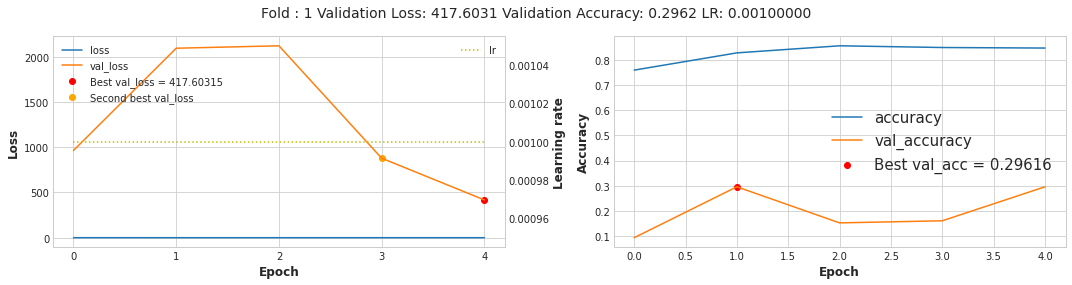

In [38]:
def plot_acc(history_f):
    fold = 0
    best_epoch = np.argmin(np.array(history_f['val_loss']))
    best_val_loss = history_f['val_loss'][best_epoch]

    fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

    fig.suptitle('Fold : '+ str(fold+1) +
                 " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                 " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                 " LR: {:0.8f}".format(history_f['lr'].min())
                 , fontsize=14)

    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])

    from_epoch = 0
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
    if best_epoch > 0:
        almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
        almost_val_loss = history_f['val_loss'][almost_epoch]
        if almost_epoch >= from_epoch:
            plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')   

    ax2 = plt.gca().twinx()
    ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
    ax2.set_ylabel('Learning rate')
    ax2.legend(loc = 'upper right')
    ax2.grid()

    best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
    best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]

    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower left')
    plt.legend(fontsize = 15)
    plt.grid(b = True, linestyle = '-')

plot_acc(pd.DataFrame(history.history))

In [39]:
np.unique(output[TARGET_FEATURE_NAME], return_counts=True)

(array([1, 2, 3, 6, 7], dtype=int8),
 array([356381, 565835,   3610,  66212,   7962]))

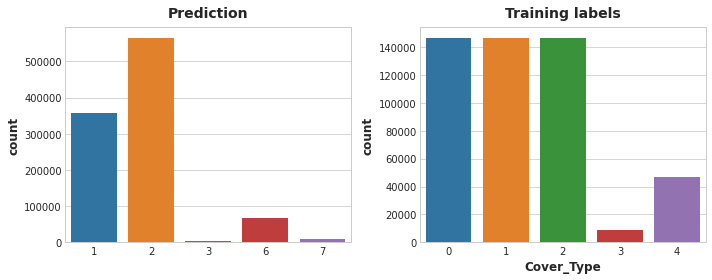

In [40]:
# Plot the distribution of the test predictions
fig, ax =plt.subplots(1,2,figsize=(10,4))
sns.countplot(x=predicted_y, ax=ax[0], orient="h").set_title("Prediction")
# Plot the distribution of the training set
sns.countplot(x = y_train[TARGET_FEATURE_NAME], ax=ax[1], orient="h").set_title("Training labels")
fig.show()

In [41]:
kt.__version__

'1.1.0'

In [42]:
keras.__version__

'2.6.0'

In [43]:
tf.__version__

'2.6.2'

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!